In [1]:
import scipy.sparse
import scipy.linalg
import numpy as np
import mkprop
from exlaser import doublewellproblem as prob
import matplotlib.pyplot as plt

n=1200
L=5
Hamiltonian = prob(n,L)

x, nrm, inr = Hamiltonian.getprop()
#tend = 5.0
tend = 0.05
u = Hamiltonian.getinitialstate()

In [2]:
np.set_printoptions(linewidth=180)
m=40
tol=1e-4
ktype=2
reo=0
tnow = 0.522345

In [3]:
# coefficient table for reference solutions
c = 3**0.5/6
cmat2 = [0.5-c, 0.5+c]
amat2 = [[0.25+c,0.25-c],[0.25-c,0.25+c]]
jexps2=len(amat2)
refsteps=4
print("use %d exponentials, requires a total time step t=%.2f"%(jexps2,sum([abs(sum(a)) for a in amat2])))

with 2 exponentials need to propagate over a total time step t=1.00


In [4]:
c=15**0.5
cmat2 = [0.5-c/10, 0.5, 0.5+c/10]
amat2 = [[0.79124225942889763, -0.080400755305553218, 0.012765293626634554],
        [-0.48931475164583259, 0.054170980027798808,-0.012069823881924156],
        [-0.029025638294289255, 0.50138457552775674,-0.025145341733509552],
        [0.0048759082890019896,-0.030710355805557892,0.30222764976657693]]
jexps2=len(amat2)
refsteps=2
print("use %d exponentials, requires a total time step t=%.2f"%(jexps2,sum([abs(sum(a)) for a in amat2])))

with 4 exponentials need to propagate over a total time step t=1.89


In [5]:
c=15**0.5
cmat2 = [0.5-c/10, 0.5, 0.5+c/10]
a1 = [0.2158389969757678,-0.0767179645915514,0.0208789676157837]
a2 = [-0.0808977963208530,-0.1787472175371576,0.0322633664310473]
a3 = [0.1806284600558301,0.4776874043509313,-0.0909342169797981]
amat2 = [a1,a2,a3,a3[::-1],a2[::-1],a1[::-1]]
jexps2=len(amat2)
refsteps=2
print("use %d exponentials, requires a total time step t=%.2f"%(jexps2,sum([abs(sum(a)) for a in amat2])))

with 6 exponentials need to propagate over a total time step t=1.91


In [6]:
c=15**0.5
cmat2 = [0.5-c/10, 0.5, 0.5+c/10]
a1 = [0.203952578716323,-0.059581898090478,0.015629319374155]
a2 = [0.133906069544898,0.314511533222506,-0.060893550742092]
a3 = [-0.014816639115506,-0.065414825819611,-0.014816639115506]
amat2 = [a1,a2,a3,a2[::-1],a1[::-1]]
jexps2=len(amat2)
refsteps=2
print("use %d exponentials, requires a total time step t=%.2f"%(jexps2,sum([abs(sum(a)) for a in amat2])))

with 5 exponentials need to propagate over a total time step t=1.19


In [7]:
c = 3**0.5/6
cmat = [0.5-c, 0.5+c]
amat=[[0.25+c,0.25-c],[0.25-c,0.25+c]]
parth1 = [1,0]
parth2 = [0,1]

chat = -0.5
jexps=len(amat)
p=4

sig = 1j
tolkry=1e-8

y0=u
mv0, _ = Hamiltonian.setupHamiltonian(tnow)
ye0 = mv0(y0)
ye0 = ye0+0j

dts = np.geomspace(1e0,2e-3,20)
errlistcfm4j2 = np.zeros(dts.size)
errestlistcfm4j2 = np.zeros(dts.size)
for dt, ij in zip(dts,range(len(dts))):
    print(ij)
    y0sub=u
    e0sub=-0.5*ye0
    for know in range(jexps):
        anow = amat[know]
        mv, dmv = Hamiltonian.setupHamiltonianCFM(anow,cmat,chat,tnow,dt)

        dHpsi = dmv(y0sub)
        Hpsi = mv(y0sub)
        HdHpsi = mv(dHpsi)
        dHHpsi = dmv(Hpsi)
        Gam11 = parth1[know]*Hpsi + dt/2*dHpsi - sig*dt**2/12*(HdHpsi-dHHpsi)
        e0sub += Gam11

        y1sub, errestkry, tkrylist, mlist1 = mkprop.expimv_pKry(mv,y0sub,tol=tolkry,t=dt,m=m,ktype=ktype,reo=reo)
        e1sub, errestkry, tkrylist, mlist2 = mkprop.expimv_pKry(mv,e0sub,tol=tolkry,t=dt,m=m,ktype=ktype,reo=reo)
        
        dHpsi = dmv(y1sub)
        Hpsi = mv(y1sub)
        HdHpsi = mv(dHpsi)
        dHHpsi = dmv(Hpsi)
        Gam12 = parth2[know]*Hpsi + dt/2*dHpsi + sig*dt**2/12*(HdHpsi-dHHpsi)
        e1sub += Gam12
        e0sub = e1sub
        y0sub = y1sub

    # computer error estimate
    y1 = y1sub
    mv2, _ = Hamiltonian.setupHamiltonian(tnow+dt)
    ye1 = mv2(y1)
    def1 = e1sub-0.5*ye1
    errestmag = dt/(p+1)*nrm(def1)
    errestlistcfm4j2[ij]=errestmag
    tolkry=1e-3*errestmag
    #print(errestmag)
    
    y0sub=u
    t=tnow
    dt2=dt/refsteps
    for j in range(refsteps):
        for know in range(jexps2):
            anow = amat2[know]
            mv, dmv = Hamiltonian.setupHamiltonianCFM(anow,cmat2,chat,t,dt2)
            y1sub, errestkry, tkrylist, mlist1 = mkprop.expimv_pKry(mv,y0sub,tol=tolkry,t=dt2,m=m,ktype=ktype,reo=reo)
            y0sub = y1sub
        t+=dt2
    testerr = nrm(y1sub-y1)
    errlistcfm4j2[ij]=testerr
    #print(testerr)
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


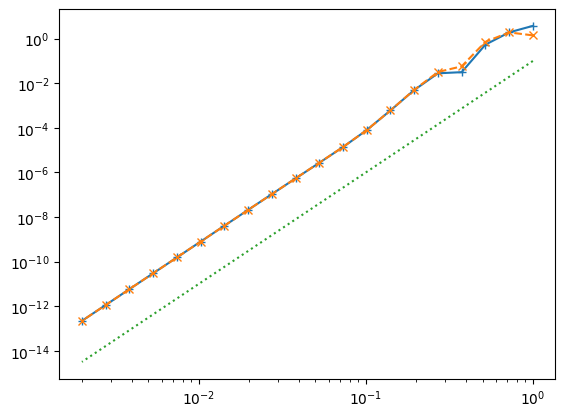

In [8]:
plt.loglog(dts, errestlistcfm4j2,'+-',dts,errlistcfm4j2,'--x',dts,1e-1*dts**(5),':')

In [10]:
c = 15**0.5
cmat = [0.5-c/10, 0.5, 0.5+c/10]
#amat = [[0.302146842308616954258187683416,
#         -0.030742768872036394116279742324,
#         0.004851603407498684079562131338],
#        [-0.029220667938337860559972036973,
#         0.505929982188517232677003929089,
#         -0.029220667938337860559972036973],
#        [0.004851603407498684079562131337,
#         -0.030742768872036394116279742324,
#         0.302146842308616954258187683417]]

amat = [[37.0/240 + 10*c/3/87, -1.0/30, 37.0/240 - 10*c/3/87],
        [-11.0/360, 23.0/45, -11.0/360],
        [37.0/240 - 10*c/3/87, -1.0/30, 37.0/240 + 10*c/3/87]]

sa=0.5/sum(amat[0])
parth1 = [sa, 0.5, 1-sa]
parth2 = [1-sa, 0.5, sa]

chat = -0.5
jexps=len(amat)
p=4

sig = 1j
tolkry=1e-8

y0=u
mv0, _ = Hamiltonian.setupHamiltonian(tnow)
ye0 = mv0(y0)
ye0 = ye0+0j

errlistcfm = np.zeros(dts.size)
errestlistcfm1 = np.zeros(dts.size)
errestlistcfm2 = np.zeros(dts.size)
for dt, ij in zip(dts,range(len(dts))):
    print(ij)
    y0sub=u
    e0sub=-0.5*ye0
    for know in range(jexps):
        anow = amat[know]
        mv, dmv = Hamiltonian.setupHamiltonianCFM(anow,cmat,chat,tnow,dt)

        dHpsi = dmv(y0sub)
        Hpsi = mv(y0sub)
        HdHpsi = mv(dHpsi)
        dHHpsi = dmv(Hpsi)
        Gam11 = parth1[know]*Hpsi + dt/2*dHpsi - sig*dt**2/12*(HdHpsi-dHHpsi)
        e0sub += Gam11

        y1sub, errestkry, tkrylist, mlist1 = mkprop.expimv_pKry(mv,y0sub,tol=tolkry,t=dt,m=m,
                                                                ktype=ktype,reo=reo)
        e1sub, errestkry, tkrylist, mlist2 = mkprop.expimv_pKry(mv,e0sub,tol=tolkry,t=dt,m=m,
                                                                ktype=ktype,reo=reo)
        
        dHpsi = dmv(y1sub)
        Hpsi = mv(y1sub)
        HdHpsi = mv(dHpsi)
        dHHpsi = dmv(Hpsi)
        Gam12 = parth2[know]*Hpsi + dt/2*dHpsi + sig*dt**2/12*(HdHpsi-dHHpsi)
        e1sub += Gam12
        e0sub = e1sub
        y0sub = y1sub

    # computer error estimate
    y1 = y1sub
    mv2, _ = Hamiltonian.setupHamiltonian(tnow+dt)
    ye1 = mv2(y1)
    def1 = e1sub-0.5*ye1
    errestmag = dt/(p+1)*nrm(def1)
    errestlistcfm1[ij]=errestmag
    tolkry=1e-3*errestmag
    #print(errestmag)
    
    y0sub=u
    t=tnow
    dt2=dt/refsteps
    for j in range(refsteps):
        for know in range(jexps2):
            anow = amat2[know]
            mv, dmv = Hamiltonian.setupHamiltonianCFM(anow,cmat2,chat,t,dt2)
            y1sub, errestkry, tkrylist, mlist1 = mkprop.expimv_pKry(mv,y0sub,tol=tolkry,t=dt2,m=m,
                                                                    ktype=ktype,reo=reo)
            y0sub = y1sub
        t+=dt2
    testerr = nrm(y1sub-y1)
    errlistcfm[ij]=testerr
    #print(testerr)
        
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


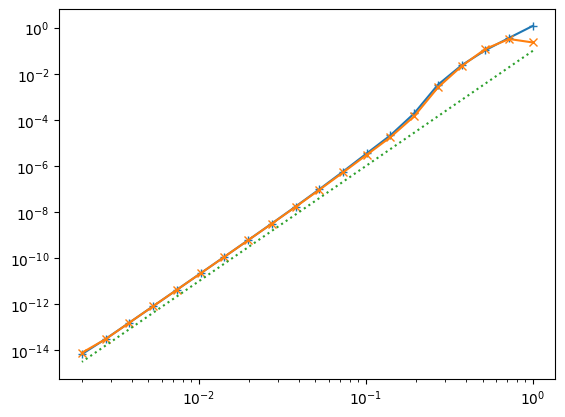

In [11]:
plt.loglog(dts, errestlistcfm1,'+-',dts,errlistcfm,'-x',dts,1e-1*dts**(p+1),':')

In [12]:
chat = -0.5
jexps=len(amat)
p=2

sig = 1j
tolkry=1e-8

y0=u
mv0, _ = Hamiltonian.setupHamiltonian(tnow)
ye0 = mv0(y0)
ye0 = ye0+0j

errlist = np.zeros(dts.size)
errestlist1 = np.zeros(dts.size)
errestlist2 = np.zeros(dts.size)
for dt, ij in zip(dts,range(len(dts))):
    print(ij)

    y0=u
    mv, dmv = Hamiltonian.setupHamiltonian(tnow+0.5*dt)

    y1, errestkry, tkrylist, mlist = mkprop.expimv_pKry(mv,y0,tol=tolkry,t=dt,m=m,
                                                        ktype=ktype,reo=reo)
    
    y0esym=mv(y0)-ye0
    defp2, errestkry, tkrylist, mlist = mkprop.expimv_pKry(mv,y0esym,tol=tolkry,t=dt,m=m,
                                                           ktype=ktype,reo=reo)
    # computer error estimate
    gam2 = mv(y1)
    mv2, _ = Hamiltonian.setupHamiltonian(tnow+dt)
    y1enext = mv2(y1)
    def1 = 0.5*(gam2-y1enext+defp2)
    errestmag = dt/(p+1)*nrm(def1)
    errestlist1[ij]=errestmag

    # computer error estimate 2
    dHpsi = dmv(y1)
    HdHpsi = mv(dHpsi)
    Hpsi = mv(y1)
    dHHpsi = dmv(Hpsi)
    defp1 = Hpsi + 0.5*dt*dHpsi + 0.5*sig*dt**2/2*(HdHpsi-dHHpsi)
    def1 = defp1-mv2(y1)
    errestmag = dt/(p+1)*nrm(def1)
    errestlist2[ij]=errestmag

    tolkry=1e-3*errestmag

    y0sub=u
    t=tnow
    dt2=dt/refsteps
    for j in range(refsteps):
        for know in range(jexps2):
            anow = amat2[know]
            mv, dmv = Hamiltonian.setupHamiltonianCFM(anow,cmat2,chat,t,dt2)
            y1sub, errestkry, tkrylist, mlist1 = mkprop.expimv_pKry(mv,y0sub,tol=tolkry,t=dt2,m=m,
                                                                    ktype=ktype,reo=reo)
            y0sub = y1sub
        t+=dt2
    testerr = nrm(y1sub-y1)
    errlist[ij]=testerr
    #print(testerr)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


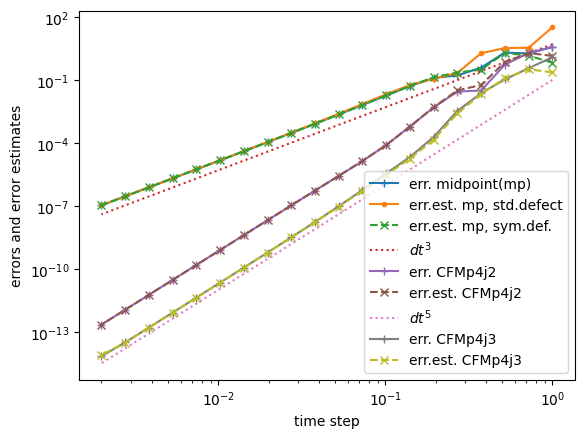

In [13]:
plt.loglog(dts, errestlist1,'+-',dts, errestlist2,'.-',dts,errlist,'--x',dts,5e0*dts**(p+1),':')
plt.loglog(dts, errestlistcfm4j2,'+-',dts,errlistcfm4j2,'--x',dts,1e-1*dts**(5),':')
plt.loglog(dts, errestlistcfm1,'+-',dts,errlistcfm,'--x');
plt.xlabel('time step')
plt.ylabel('errors and error estimates')
plt.gca().legend(('err. midpoint(mp)','err.est. mp, std.defect','err.est. mp, sym.def.','$dt^3$','err. CFMp4j2','err.est. CFMp4j2','$dt^5$','err. CFMp4j3','err.est. CFMp4j3'))
#plt.savefig("asymptoticerror.pdf", format="pdf", bbox_inches="tight")
plt.savefig("asymptoticerror.png")

In [14]:
c = 15**0.5
cmat = [0.5-c/10, 0.5, 0.5+c/10]
a1 = [(10+c)/180, -1/9, (10-c)/180]
a2 = [(15+8*c)/180,1/3,(15-8*c)/180]
amat = [a1,a2,a2[::-1],a1[::-1]]
parth1 = [1,1,0,0]
parth2 = [0,0,1,1]
p=4

chat = -0.5
jexps=len(amat)
p=4
hasexpV = True

sig = 1j
tolkry=1e-8

y0=u
mv0, _ = Hamiltonian.setupHamiltonian(tnow)
ye0 = mv0(y0)
ye0 = ye0+0j
dts = np.geomspace(1e0,2e-3,20)
errlistbbk = np.zeros(dts.size)
errestlistbbk = np.zeros(dts.size)
for dt, ij in zip(dts,range(len(dts))):
    print(ij)
    y0sub=u
    e0sub=-0.5*ye0
    for know in range(jexps):
        anow = amat[know]
        mv, dmv = Hamiltonian.setupHamiltonianCFM(anow,cmat,chat,tnow,dt)

        dHpsi = dmv(y0sub)
        Hpsi = mv(y0sub)
        HdHpsi = mv(dHpsi)
        dHHpsi = dmv(Hpsi)
        Gam11 = parth1[know]*Hpsi + dt/2*dHpsi - sig*dt**2/12*(HdHpsi-dHHpsi)
        e0sub += Gam11

        if ((hasexpV) and (sum(anow)<1e-12)):
            y1sub = Hamiltonian.applyexpV(sig,dt,y0sub)
            e1sub = Hamiltonian.applyexpV(sig,dt,e0sub)
            mlist1, mlist2 = [], []
        else:
            y1sub, errestkry, tkrylist, mlist1 = mkprop.expimv_pKry(mv,y0sub,tol=tolkry,
                                                             t=dt,m=m,ktype=ktype,reo=reo)
            e1sub, errestkry, tkrylist, mlist2 = mkprop.expimv_pKry(mv,e0sub,tol=tolkry,
                                                             t=dt,m=m,ktype=ktype,reo=reo)
            
        dHpsi = dmv(y1sub)
        Hpsi = mv(y1sub)
        HdHpsi = mv(dHpsi)
        dHHpsi = dmv(Hpsi)
        Gam12 = parth2[know]*Hpsi + dt/2*dHpsi + sig*dt**2/12*(HdHpsi-dHHpsi)
        e1sub += Gam12
        e0sub = e1sub
        y0sub = y1sub

    # computer error estimate
    y1 = y1sub
    mv2, _ = Hamiltonian.setupHamiltonian(tnow+dt)
    ye1 = mv2(y1)
    def1 = e1sub-0.5*ye1
    errestmag = dt/(p+1)*nrm(def1)
    errestlistbbk[ij]=errestmag
    tolkry=1e-3*errestmag
    #print(errestmag)

    y0sub=u
    t=tnow
    dt2=dt/refsteps
    for j in range(refsteps):
        for know in range(jexps2):
            anow = amat2[know]
            mv, dmv = Hamiltonian.setupHamiltonianCFM(anow,cmat2,chat,t,dt2)
            y1sub, errestkry, tkrylist, mlist1 = mkprop.expimv_pKry(mv,y0sub,tol=tolkry,t=dt2,m=m,
                                                                        ktype=ktype,reo=reo)
            y0sub = y1sub
        t+=dt2
    testerr = nrm(y1sub-y1)
    errlistbbk[ij]=testerr
    #print(testerr)
print("done")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done


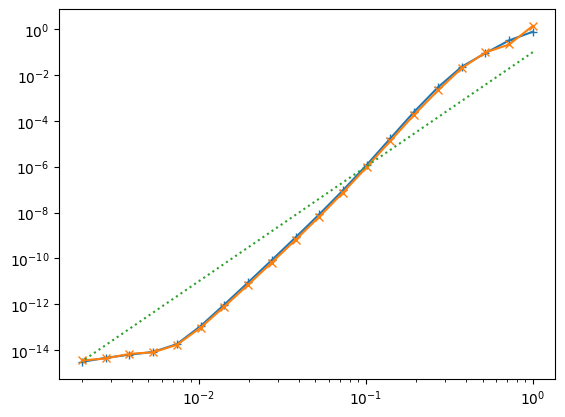

In [15]:
plt.loglog(dts, errestlistbbk,'+-',dts,errlistbbk,'-x',dts,1e-1*dts**(p+1),':')

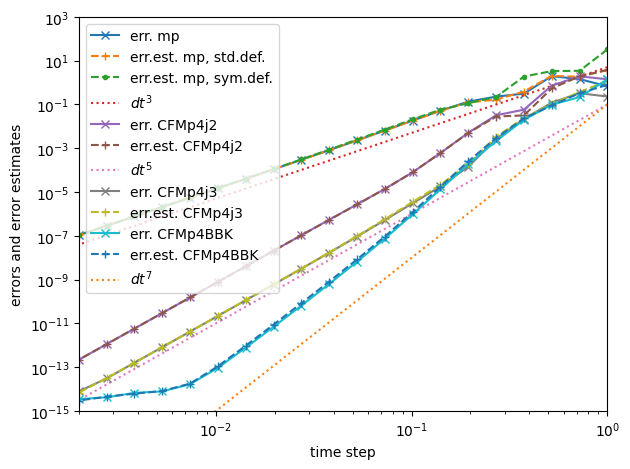

In [34]:
plt.loglog(dts,errlist,'-x',dts, errestlist1,'+--',dts, errestlist2,'.--',dts,5e0*dts**3,':')
plt.loglog(dts,errlistcfm4j2,'-x',dts, errestlistcfm4j2,'+--',dts,1e-1*dts**5,':')
plt.loglog(dts,errlistcfm,'-x',dts, errestlistcfm1,'+--')
plt.loglog(dts,errlistbbk,'-x',dts, errestlistbbk,'+--',dts,1e-1*dts**7,':');
plt.xlabel('time step')
plt.ylabel('errors and error estimates')
plt.gca().legend(('err. mp','err.est. mp, std.def.','err.est. mp, sym.def.','$dt^3$',
                  'err. CFMp4j2','err.est. CFMp4j2','$dt^5$',
                  'err. CFMp4j3','err.est. CFMp4j3',
                  'err. CFMp4BBK','err.est. CFMp4BBK','$dt^7$'), loc='upper left')
#                 bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlim(2e-3,1e0)
plt.ylim(1e-15,1e3)
plt.tight_layout()
plt.savefig("asymptoticerror.pdf", format="pdf", bbox_inches="tight")
plt.savefig("asymptoticerror.png")